In [263]:
# loading libraries
import igor.igorpy as igor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [62]:
#load excel file
waveInfo = pd.read_excel('2016.10.26_Cell1.xlsx')

#is changing the index necessary? If so should do automatically
waveInfo.tail()

,waveNum,waveName,stimInt,notes
73,74,w80,600.0,y
74,75,w81,800.0,y
75,76,w82,800.0,y
76,77,w83,1000.0,lastMax
77,78,w84,1000.0,lastMax


In [32]:
date = '2016.10.19'
cellNum = 1
age = 15

#Load csv
igor = pd.read_csv('igorForPython.csv', index_col = 0)

In [48]:
igorWaves = igor.pivot(index='sec', columns='id', values='pA')
igorWaves.head()

id,w1,w10,w100,w101,w102,w103,w104,w105,w106,w107,...,w90,w91,w92,w93,w94,w95,w96,w97,w98,w99
sec,,,,,,,,,,,,,,,,,,,,,
0.00000,5.283691,-1.231331,1.660751,0.580154,0.916258,0.352314,-0.986023,0.143188,-2.377863,-1.548706,...,-1.453011,-0.746902,-3.679989,-0.158188,0.745697,3.199509,2.005676,-2.347969,-0.296299,-0.826656
0.00001,-0.965820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.00002,-4.403320,-0.606361,2.285721,0.580154,1.228743,0.664799,-0.361053,-1.106750,-3.627802,-2.486160,...,-1.765495,-1.684357,-3.679989,-0.470673,1.370667,2.262054,2.005676,-2.660454,-0.921268,0.423283
0.00003,-6.590332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.00004,-5.653320,-0.293877,1.348267,1.517609,1.228743,-0.272655,0.263916,0.143188,-3.940287,-0.923737,...,-1.453011,-0.746902,-3.367504,-0.158188,1.683151,1.949570,3.255615,-2.972939,-1.858723,-1.139141


In [304]:
#waveName column of waveInfo
waveNames = waveInfo['waveName']

#filter igorWaves by waveInfo
wavesToAnalyze = igorWaves.filter(waveNames)
wavesToAnalyze = wavesToAnalyze.dropna(axis = 0)
#dropping NaNs removes tail end of tau trace; will have to specify tau trace separately

wavesToAnalyze.head()

id,w7,w8,w9,w10,w11,w12,w13,w14,w15,w16,...,w75,w76,w77,w78,w79,w80,w81,w82,w83,w84
sec,,,,,,,,,,,,,,,,,,,,,
0.00000,0.948830,-3.059967,1.289867,-1.231331,-0.434429,2.303024,1.274933,0.613708,0.796894,1.317093,...,4.723364,1.359512,-1.399342,1.061974,1.475237,2.330578,-3.692544,-1.730488,-1.836338,-1.835079
0.00002,0.323860,-3.059967,-0.897526,-0.606361,-1.684368,2.615509,0.024994,0.301224,2.671803,2.567032,...,4.098394,1.359512,-1.711826,2.624397,0.850267,2.018093,-3.067575,-0.793034,-2.461308,-1.522594
0.00004,0.323860,-2.434998,0.039928,-0.293877,-1.996853,1.053085,0.649963,-0.636230,2.359318,2.567032,...,3.785910,1.359512,-1.711826,2.624397,2.412691,2.018093,-3.692544,-2.355457,-1.836338,-1.522594
0.00006,0.948830,-2.747482,0.039928,0.956062,-0.746914,0.740601,0.962448,0.613708,1.421864,1.942062,...,4.098394,1.671997,-1.086857,1.999428,0.850267,2.330578,-3.692544,-1.730488,-2.773792,-2.772533
0.00008,-0.301109,-1.185059,-1.210011,0.643578,-1.684368,2.303024,-0.287491,-0.011261,1.421864,3.504486,...,3.785910,1.047028,-1.711826,2.624397,1.162752,2.330578,-1.505151,-0.480549,-2.461308,-2.147564


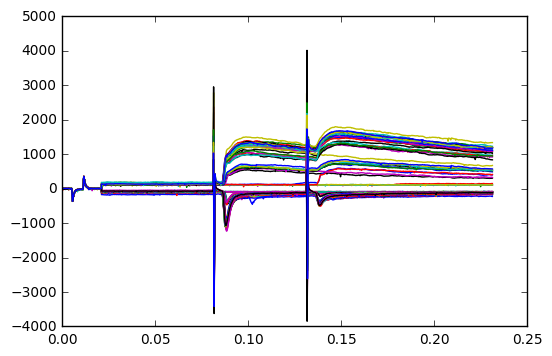

In [66]:
plt.plot(wavesToAnalyze)
plt.show()

In [335]:
#time points

timeBeginFirstArtifact = 0.081 
timeEndFirstArtifact = 0.0845 #generally 0.0845
timeBegin2Artifact = 0.131
timeEnd2Artifact = 0.134

In [336]:
#remove stimulus artifacts

wavesToAnalyze[timeBeginFirstArtifact:timeEndFirstArtifact] = np.nan
wavesToAnalyze[timeBegin2Artifact:timeEnd2Artifact] = np.nan

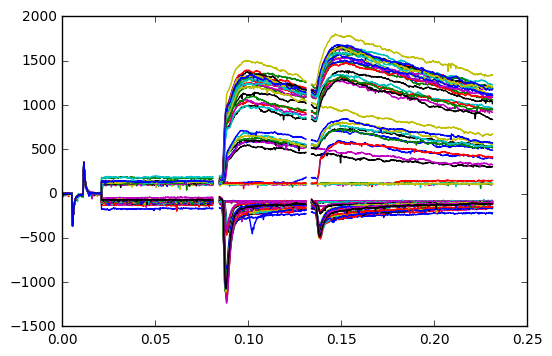

In [337]:
plt.plot(wavesToAnalyze)
plt.show()